In [5]:
from decoder_new import *
from encoder import *
from data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


In [6]:


def validate(val_loader, encoder, decoder, criterion, maxSeqLen,
             vocab, use_gpu = True, calculate_bleu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()

    
    references = list()
    hypotheses = list() 
    
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        bleu1_avg = 0
        bleu4_avg = 0
        
        for i, (inputs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)
                caps = caps.to(device)

                        
            enc_out = encoder(inputs)
            actual_lengths = allcaps
            
            
            
            temperature = 1
            test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)

            test_pred_sample = test_pred[0].cpu().numpy()          

            

            
            #Build a list of the predicted sentences
            # Convert word_ids to words
            sampled_caption = []

            for word_id in test_pred_sample:
                word = vocab.idx2word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            hypotheses.append(sampled_caption)                
            #if i % 750 ==0:
                #print ('generated sentence: ',sentence)            
                #print(type(sampled_caption))        
                #print(sampled_caption)        
                #print('len(generated_sentence): ',len(sampled_caption))

                
            #targets = pack_padded_sequence(labels, lengths, batch_first=True)[0]
        
            outputs = decoder(caps, enc_out, actual_lengths)
#             if i % 1000 == 0:
#                 print('VAL: outputs shape: ', outputs.size())
            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            new_outputs[:inputs.shape[0],:maxSeqLen, 0] = torch.ones((inputs.shape[0], maxSeqLen))
#             for dim in range(maxSeqLen):
#                 for b in range(inputs.shape[0]):
#                     new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            
            #del inputs

            
            loss = criterion(new_outputs, Variable(caps.long()))
            loss_avg += loss
            count+=1
            
            #del outputs            
            
            #print('VAL: loss: ', loss)

            
            
            caps_array = caps.cpu().numpy()  
            # Convert word_ids to words
            reference_caption = []
            sampled_caption = []
            
            for word_id in caps_array[0]:
                word = vocab.idx2word[word_id]
                reference_caption.append(word)
                if word == '<end>':
                    break
            ref_sentence = ' '.join(reference_caption)
            #if i % 500 == 0:
                #print('ref_sentence: ', ref_sentence)
                #print('len(ref_sentence): ',len(reference_caption))
            references.append(reference_caption)   
        

        
        
            #print('len(references)', len(references))
            #print('len(hypotheses)', len(hypotheses))
            #print('references: ', references)
            #print('hypotheses: ', hypotheses)
        

            # Calculate BLEU-4 scores
            if calculate_bleu:
                bleu4 = corpus_bleu(references, hypotheses)                
                bleu1 = corpus_bleu(references, hypotheses,weights=(1.0, 0, 0, 0))
                #print('bleu4: ', bleu4)        
                #print('bleu1: ', bleu1)  
                bleu4_avg+=bleu4
                bleu1_avg+=bleu1
            
            del caps
            del outputs            
            
            
            #if i % 100 == 0:
            #    break
                
                
        if calculate_bleu:
            loss_avg  = loss_avg/count
            bleu4_avg = bleu4_avg/count
            bleu1_avg = bleu1_avg/count 
            #print('VAL: loss_avg: ', loss_avg)
            #print('VAL: bleu4_avg: ', bleu4_avg)
            #print('VAL: bleu1_avg: ', bleu1_avg)
        
        
        
        
            
    return loss_avg

In [7]:
def trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    parameters = list(encoder.fc.parameters())
    parameters.extend(list(decoder.parameters()))
    optimizer = optim.Adam(parameters, lr=5e-3)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")
#         encoder = torch.nn.DataParallel(encoder)
#         decoder = torch.nn.DataParallel(decoder)
        
        encoder.to(device)
        decoder.to(device)
        
        
    
    val_loss_set = []
    val_acc_set = []
    val_iou_set = []
    
    
    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 10
    earlyStopDelta = 5
    for epoch in range(epochs):
        ts = time.time()

        #import pdb; pdb.set_trace()                     
        for iter, (inputs, labels, lengths, actual_lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()
            
            
            encoder.train()
            decoder.train()
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            
                
            enc_out = encoder(inputs)
            #print('enc out shape: ', enc_out.size())
            temperature = 1
#             test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)
#             for b in range(batch_size):
#                 flag = False
#                 for wi in range(maxSeqLen):
#                     if test_pred[b, wi] == 2:
#                         flag = True
#                     if flag:
#                         test_pred[b, wi] = 0
            #print('test pred: ', test_pred)
            #print('test pred shape: ', test_pred.size())
            
#             targets = pack_padded_sequence(labels, lengths, batch_first=True)[0]
            
            
            outputs = decoder(labels, enc_out, actual_lengths) #calls forward
#             print('outputs shape: ', outputs.size())
            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            new_outputs[:inputs.shape[0],:maxSeqLen, 0] = torch.ones((inputs.shape[0], maxSeqLen))
#             for dim in range(maxSeqLen):
#                 for b in range(inputs.shape[0]):
#                     new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
#             print('new outputs shape: ', new_outputs.size())
#             print('labels shape: ', labels.size())
            
            loss = criterion(new_outputs, Variable(labels.long()))
            del labels
            del outputs

            loss.backward()
#             loss = loss#.item()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss))
                
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

        for b in range(inputs.shape[0]):
            caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
            img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
            plt.imshow(img)
                    
            plt.show()
            print("Caption: " + caption)

        
        # calculate val loss each epoch
        val_loss  = validate(val_loader, encoder, decoder, criterion,maxSeqLen,
                             vocab, use_gpu)
        val_loss_set.append(val_loss)

        
#         print("epoch {}, time {}, train loss {}, val loss {}, val acc {}, val iou {}".format(epoch, time.time() - ts,
#                                                                                                loss, val_loss,
#                                                                                                val_acc,
#                                                                                                val_iou))        
        training_loss.append(loss)
        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
#             file.write("\n Validation Loss: " + str(val_loss_set[-1]))
#             file.write("\n Validation acc:  " + str(val_acc_set[-1]))
#             file.write("\n Validation iou:  " + str(val_iou_set[-1]) + "\n ")                                             
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(model, name)
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
        # If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
    with open(logname_summary, "a") as file:
            file.write("Summary!\n")
            file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss: " + str(val_loss_set))
            file.write("\n Validation acc:  " + str(val_acc_set))
            file.write("\n Validation iou:  " + str(val_iou_set) + "\n ")
            
        
    #return val_loss_set, val_acc_set, val_iou_set

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Loading results to logfile: ./logs/LSTM71.log
Loading Summary to : ./logs/LSTM_summary71.log


1it [00:02,  2.17s/it]

epoch0, iter0, loss: -0.6428938508033752


102it [00:20,  5.94it/s]

epoch0, iter100, loss: -0.6970635652542114


202it [00:38,  5.56it/s]

epoch0, iter200, loss: -0.7946699857711792


302it [00:56,  5.73it/s]

epoch0, iter300, loss: -0.6894773840904236


402it [01:14,  5.48it/s]

epoch0, iter400, loss: -0.7544902563095093


502it [01:32,  5.73it/s]

epoch0, iter500, loss: -0.6426495313644409


602it [01:50,  5.60it/s]

epoch0, iter600, loss: -0.7728815078735352


702it [02:07,  5.62it/s]

epoch0, iter700, loss: -0.7880407571792603


802it [02:24,  5.85it/s]

epoch0, iter800, loss: -0.8346400260925293


902it [02:42,  5.75it/s]

epoch0, iter900, loss: -0.8392629623413086


1002it [02:59,  5.59it/s]

epoch0, iter1000, loss: -0.8167827129364014


1102it [03:17,  5.92it/s]

epoch0, iter1100, loss: -0.8552852869033813


1202it [03:35,  5.76it/s]

epoch0, iter1200, loss: -0.8281634449958801


1302it [03:52,  5.83it/s]

epoch0, iter1300, loss: -0.8558295369148254


1402it [04:10,  5.56it/s]

epoch0, iter1400, loss: -0.8333609700202942


1502it [04:28,  5.49it/s]

epoch0, iter1500, loss: -0.8447688817977905


1602it [04:46,  5.46it/s]

epoch0, iter1600, loss: -0.8305509090423584


1702it [05:04,  5.76it/s]

epoch0, iter1700, loss: -0.8199618458747864


1802it [05:22,  5.66it/s]

epoch0, iter1800, loss: -0.830264687538147


1902it [05:40,  5.50it/s]

epoch0, iter1900, loss: -0.8179728984832764


2002it [05:58,  5.50it/s]

epoch0, iter2000, loss: -0.8483889698982239


2102it [06:16,  5.57it/s]

epoch0, iter2100, loss: -0.858065664768219


2202it [06:34,  5.61it/s]

epoch0, iter2200, loss: -0.8437852263450623


2302it [06:52,  5.65it/s]

epoch0, iter2300, loss: -0.82008957862854


2402it [07:10,  5.68it/s]

epoch0, iter2400, loss: -0.8411245346069336


2502it [07:27,  5.65it/s]

epoch0, iter2500, loss: -0.8450137972831726


2602it [07:45,  5.72it/s]

epoch0, iter2600, loss: -0.8367063999176025


2702it [08:03,  5.71it/s]

epoch0, iter2700, loss: -0.8316806554794312


2802it [08:21,  5.56it/s]

epoch0, iter2800, loss: -0.857659637928009


2902it [08:39,  5.57it/s]

epoch0, iter2900, loss: -0.8525781631469727


3002it [08:57,  5.56it/s]

epoch0, iter3000, loss: -0.8211658000946045


3102it [09:15,  5.70it/s]

epoch0, iter3100, loss: -0.842806339263916


3202it [09:33,  5.49it/s]

epoch0, iter3200, loss: -0.8620655536651611


3302it [09:51,  5.61it/s]

epoch0, iter3300, loss: -0.852138876914978


3313it [09:54,  5.57it/s]


epoch0, iter3312, loss: -0.8493703007698059, epoch duration: 596.2709903717041


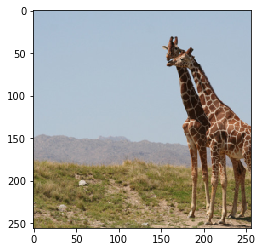

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


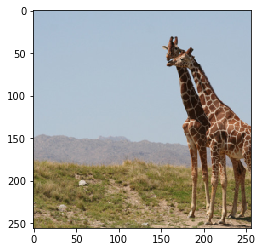

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


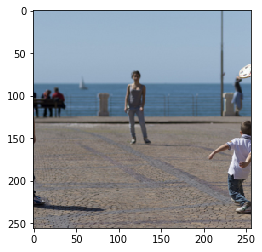

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


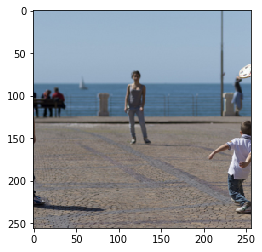

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


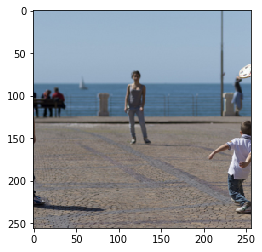

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


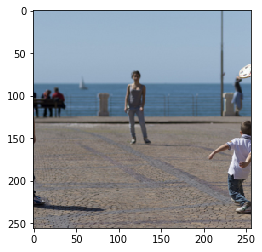

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


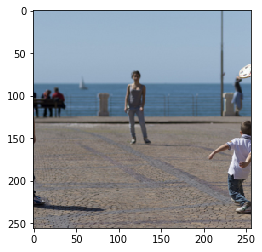

Caption: <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a


AttributeError: 'int' object has no attribute 'idx2word'

In [8]:
if __name__=='__main__':
    with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
        
    with open('TestImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        testIds = list(reader)[0]
    
    trainIds = [int(i) for i in trainIds]
    testIds = [int(i) for i in testIds]
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/images/train/"
    testRoot = "./data/images/test/"
    
    trainValJson = "./data/annotations/captions_train2014.json"
    testJson = "./data/annotations/captions_val2014.json"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 256
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 20
    
    
    trainDl = get_loader(trainValRoot, trainValJson, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=False, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValJson, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testJson, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 1024
    maxSeqLen = 56
    hidden_dim = 128
    
    encoder = Encoder(encoded_feature_dim)
    # Turn off all gradients in encoder
    for param in encoder.parameters():
        param.requires_grad = False
    # Turn on gradient of final hidden layer for fine tuning
    for param in encoder.fc.parameters():
        param.requires_grad = True
    decoder = Decoder(encoded_feature_dim, 128, hidden_dim, vocab.idx)
    
    criterion = nn.NLLLoss()
    
    epochs = 100
    trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        trainDl, valDl, testDl, "LSTM",
                        batch_size, maxSeqLen, vocab)

In [ ]:
%debug